## Import training/test files in Pandas

In [1]:
import pandas as pd
import os 

print(os.getcwd())

/home/ubuntu/Desktop/multi-task-learning


In [2]:
train_data = pd.read_csv(os.path.join(os.getcwd() + '/data/20191120_training_csv'))
test_data = pd.read_csv(os.path.join(os.getcwd() + '/data/20191120_test_csv'))

In [3]:
# Note: we are enabling eager execution for debugging!

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mondeique

## example code

In [4]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
    print(img)
    print(labels)

tf.Tensor(
[b'./data/cropped-bag-images-dev/GQY2HJFKZ2J_1.jpg'
 b'./data/cropped-bag-images-dev/GCHQY0O9SOH_1.jpg'
 b'./data/cropped-bag-images-dev/aug_data/trapezoid/aug_K4NEBQ7AORX_1.jpg_85.jpg'
 b'./data/cropped-bag-images-dev/52J5JS9VIBK_1.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[ 5  1  5 11]
 [ 7  2  6 11]
 [ 3  2  6 11]
 [ 2  1  6 11]], shape=(4, 4), dtype=int64)


## parse function from csv

In [5]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
    print(filename)
    image_string = tf.read_file(filename) 
    print(image_string)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) 
    image_resized = tf.image.resize_images(image_decoded, [160, 160])
    image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
    label = tf.concat([label[:]], axis=0)
    return {"x": image_resized}, label

## Make Dataset

In [6]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe.iloc[:, 0].tolist())

    # Load the labels
    labels = tf.constant(dataframe.iloc[:, 1:].values)

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
        dataset = dataset.batch(64)
    else:
        dataset = dataset.repeat().shuffle(1000).batch(64)

    return dataset

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
tf.Tensor([ 5  1  5 11], shape=(4,), dtype=int64)
tf.Tensor([ 7  2  6 11], shape=(4,), dtype=int64)


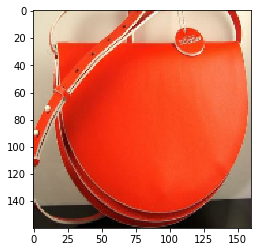

In [7]:
# Check the image & some labels
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
    plt.imshow(imgs['x'][0] / 255)
    print(labels[0])
    print(labels[1])

## extract feature

In [8]:
def extract_features(features):
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, 160, 160, 3])

    # First convolutive layer
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Second convolutive layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Third convolutive layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    
    # Fifth convolutive layer
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)

    # Sixth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=128, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)

    # Dense Layer (Fully Connected Layer)
    flat = tf.reshape(conv4, [-1, 20 * 20 * 128])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
    return dense

## input_fn & main estimator model

In [9]:
# Need to disable the eager execution at this point
import numpy as np
import tensorflow as tf

def multi_input_fn(data, is_eval=False):
    features, labels = input_fn(data, is_eval=is_eval).make_one_shot_iterator().get_next()
    return features, {'shape': labels[:, 0], 'cover': labels[:, 1], 'charm': labels[:, 2], 'pattern': labels[:, 3]}

In [10]:
def multi_cnn_model_fn(features, labels, mode):

    dense = extract_features(features)

    # Predictions for each task
    logits_shape = tf.layers.dense(inputs=dense, units=11)
    logits_cover = tf.layers.dense(inputs=dense, units=3)
    logits_charm = tf.layers.dense(inputs=dense, units=7)
    logits_pattern = tf.layers.dense(inputs=dense, units=12)
    
    # Make predictions
    
    predicted_shape_class = tf.argmax(logits_shape, 1)
    predicted_cover_class = tf.argmax(logits_cover, 1)
    predicted_charm_class = tf.argmax(logits_charm, 1)
    predicted_pattern_class = tf.argmax(logits_pattern, 1)
    
    logits = {'shape': logits_shape, 'cover': logits_cover, 
              'charm': logits_charm, 'pattern': logits_pattern}
    
    outputs = {
        "predicted_shape_class": predicted_shape_class,
        "predicted_cover_class": predicted_cover_class,
        "predicted_charm_class": predicted_charm_class,
        "predicted_pattern_class": predicted_pattern_class
    }
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer()
    
    # We just want the predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

    # If not in mode.PREDICT, compute the loss 
    shape_loss = tf.losses.sparse_softmax_cross_entropy(labels=labels['shape'], logits=logits_shape)
    cover_loss = tf.losses.sparse_softmax_cross_entropy(labels=labels['cover'], logits=logits_cover)
    charm_loss = tf.losses.sparse_softmax_cross_entropy(labels=labels['charm'], logits=logits_charm)
    pattern_loss = tf.losses.sparse_softmax_cross_entropy(labels=labels['pattern'], logits=logits_pattern)
    total_loss = shape_loss + cover_loss + charm_loss + pattern_loss

    # TRAIN MODE 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=total_loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=total_loss, train_op=train_op)

    # If not PREDICT or TRAIN, then we are evaluating the model
    eval_metric_ops = {
        "shape_accuracy": tf.metrics.accuracy(
            labels=labels['shape'], predictions=outputs["predicted_shape_class"]), 
        "cover_accuracy": tf.metrics.accuracy(
            labels=labels['cover'], predictions=outputs["predicted_cover_class"]), 
        "charm_accuracy": tf.metrics.accuracy(
            labels=labels['charm'], predictions=outputs["predicted_charm_class"]), 
        "pattern_accuracy": tf.metrics.accuracy(
            labels=labels['pattern'], predictions=outputs["predicted_pattern_class"]), 
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=total_loss, eval_metric_ops=eval_metric_ops)
    

## estimator 선언 및 training / evaluation / test

In [11]:
multitask_classifier = tf.estimator.Estimator(model_fn=multi_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpoves15jc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3e903fb150>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
multitask_classifier.train(input_fn=lambda: multi_input_fn(train_data), steps=30000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpoves15jc/model.ckpt.
INFO:tensorflow:loss = 68.25652, step = 1
INFO:tensorflow:global_step/sec: 1.12663
INFO:tensorflow:loss = 2.9209337, step = 101 (88.761 sec)
INFO:tensorflow:global_step/sec: 1.13855
INFO:tensorflow:loss = 1.0854232, step = 201 (87.831 sec)
INFO:tensorflow:global_step/sec: 1.14001
INFO:tensorflow:loss = 0.24387504, step = 301 (87.718 sec)
INFO:tensorflow:global_step/sec: 1.1403
INFO:tensorflow:loss = 0.07371551, step = 401 (87.696 sec)
INFO:tensorflow:global_step/sec: 1.13774
INFO:tensorflow:loss = 0.100628726, step = 501 (87.894 sec)
INFO:tensorflow:global_step/sec: 1.14005
INFO:tensorflow:loss = 0.0746838, step = 601 (8

INFO:tensorflow:global_step/sec: 1.14121
INFO:tensorflow:loss = 1.0441862e-05, step = 5101 (87.627 sec)
INFO:tensorflow:global_step/sec: 1.14499
INFO:tensorflow:loss = 7.742922e-06, step = 5201 (87.337 sec)
INFO:tensorflow:global_step/sec: 1.14391
INFO:tensorflow:loss = 6.0572784e-06, step = 5301 (87.419 sec)
INFO:tensorflow:global_step/sec: 1.1422
INFO:tensorflow:loss = 3.85938e-06, step = 5401 (87.550 sec)
INFO:tensorflow:Saving checkpoints for 5484 into /tmp/tmpoves15jc/model.ckpt.
INFO:tensorflow:global_step/sec: 1.14022
INFO:tensorflow:loss = 4.3753244e-06, step = 5501 (87.702 sec)
INFO:tensorflow:global_step/sec: 1.14196
INFO:tensorflow:loss = 1.2771836e-05, step = 5601 (87.568 sec)
INFO:tensorflow:global_step/sec: 1.13829
INFO:tensorflow:loss = 4.988119e-06, step = 5701 (87.852 sec)
INFO:tensorflow:global_step/sec: 1.14219
INFO:tensorflow:loss = 5.561806e-06, step = 5801 (87.551 sec)
INFO:tensorflow:global_step/sec: 1.14443
INFO:tensorflow:loss = 7.346176e-06, step = 5901 (87.38

INFO:tensorflow:loss = 1.1920926e-07, step = 12201 (87.602 sec)
INFO:tensorflow:global_step/sec: 1.14354
INFO:tensorflow:loss = 1.15483985e-07, step = 12301 (87.448 sec)
INFO:tensorflow:Saving checkpoints for 12340 into /tmp/tmpoves15jc/model.ckpt.
INFO:tensorflow:global_step/sec: 1.14187
INFO:tensorflow:loss = 8.940695e-08, step = 12401 (87.576 sec)
INFO:tensorflow:global_step/sec: 1.13963
INFO:tensorflow:loss = 6.519257e-08, step = 12501 (87.748 sec)
INFO:tensorflow:global_step/sec: 1.13917
INFO:tensorflow:loss = 6.332993e-08, step = 12601 (87.783 sec)
INFO:tensorflow:global_step/sec: 1.14059
INFO:tensorflow:loss = 1.080334e-07, step = 12701 (87.674 sec)
INFO:tensorflow:global_step/sec: 1.13984
INFO:tensorflow:loss = 8.754431e-08, step = 12801 (87.731 sec)
INFO:tensorflow:global_step/sec: 1.14002
INFO:tensorflow:loss = 1.247972e-07, step = 12901 (87.718 sec)
INFO:tensorflow:global_step/sec: 1.09716
INFO:tensorflow:loss = 1.210719e-07, step = 13001 (91.145 sec)
INFO:tensorflow:Saving 

INFO:tensorflow:global_step/sec: 1.13503
INFO:tensorflow:loss = 1.862645e-08, step = 19301 (88.104 sec)
INFO:tensorflow:global_step/sec: 1.13586
INFO:tensorflow:loss = 7.45058e-09, step = 19401 (88.040 sec)
INFO:tensorflow:global_step/sec: 1.13839
INFO:tensorflow:loss = 1.117587e-08, step = 19501 (87.843 sec)
INFO:tensorflow:global_step/sec: 1.1382
INFO:tensorflow:loss = 0.0, step = 19601 (87.858 sec)
INFO:tensorflow:global_step/sec: 1.13464
INFO:tensorflow:loss = 1.6763805e-08, step = 19701 (88.133 sec)
INFO:tensorflow:Saving checkpoints for 19739 into /tmp/tmpoves15jc/model.ckpt.
INFO:tensorflow:global_step/sec: 1.13519
INFO:tensorflow:loss = 1.490116e-08, step = 19801 (88.092 sec)
INFO:tensorflow:global_step/sec: 1.13773
INFO:tensorflow:loss = 1.30385e-07, step = 19901 (87.894 sec)
INFO:tensorflow:global_step/sec: 1.14
INFO:tensorflow:loss = 1.1272311, step = 20001 (87.720 sec)
INFO:tensorflow:global_step/sec: 1.14501
INFO:tensorflow:loss = 0.1614504, step = 20101 (87.336 sec)
INFO:

INFO:tensorflow:loss = 5.9976537e-06, step = 26401 (87.071 sec)
INFO:tensorflow:global_step/sec: 1.14957
INFO:tensorflow:loss = 9.180879e-06, step = 26501 (86.989 sec)
INFO:tensorflow:global_step/sec: 1.14878
INFO:tensorflow:loss = 2.5760248e-06, step = 26601 (87.048 sec)
INFO:tensorflow:Saving checkpoints for 26631 into /tmp/tmpoves15jc/model.ckpt.
INFO:tensorflow:global_step/sec: 1.14856
INFO:tensorflow:loss = 3.2670573e-06, step = 26701 (87.066 sec)
INFO:tensorflow:global_step/sec: 1.15126
INFO:tensorflow:loss = 4.483357e-06, step = 26801 (86.861 sec)
INFO:tensorflow:global_step/sec: 1.15458
INFO:tensorflow:loss = 2.4307437e-06, step = 26901 (86.612 sec)
INFO:tensorflow:global_step/sec: 1.14817
INFO:tensorflow:loss = 1.6316731e-06, step = 27001 (87.095 sec)
INFO:tensorflow:global_step/sec: 1.15165
INFO:tensorflow:loss = 9.480849e-07, step = 27101 (86.832 sec)
INFO:tensorflow:global_step/sec: 1.15172
INFO:tensorflow:loss = 1.484522e-06, step = 27201 (86.827 sec)
INFO:tensorflow:globa

In [13]:
multitask_classifier.evaluate(input_fn=lambda: multi_input_fn(test_data, is_eval=True))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-22T17:13:51Z


INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpoves15jc/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-22-17:13:52
INFO:tensorflow:Saving dict for global step 30000: charm_accuracy = 0.8729792, cover_accuracy = 0.8683603, global_step = 30000, loss = 20.509129, pattern_accuracy = 0.62355655, shape_accuracy = 0.5588915
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /tmp/tmpoves15jc/model.ckpt-30000


{'charm_accuracy': 0.8729792,
 'cover_accuracy': 0.8683603,
 'loss': 20.509129,
 'pattern_accuracy': 0.62355655,
 'shape_accuracy': 0.5588915,
 'global_step': 30000}

In [ ]:
multitask_classifier.predict(lambda: input_fn(test_data, is_eval=True))

## restore trained model 

In [ ]:
with tf.Session() as sess :

    # Saver instance 를 생성한다.
    # Saver.restore(sess, ckpt_path)

    saver = tf.train.import_meta_graph('/tmp/tmpv28t5kpm/model.ckpt-5563.meta')
    saver.restore(sess, tf.train.latest_checkpoint('/tmp/tmpv28t5kpm/'))